# Summary

## NLTK

NLTK (Natural Language Toolkit) is a versatile library in Python for working with human language data and has a wide range of functionalities. While it's known for providing easy access to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, newer libraries have also gained popularity for certain tasks, especially those related to machine learning and deep learning.

## Models

**Deep Averaging Network (DAN)**
Overview: Deep Averaging Networks (DANs) are a class of neural networks designed for text classification tasks. They operate by averaging word embeddings for all words in a document, creating a document representation that is then passed through one or more dense layers to produce a classification. DANs are remarkably simple yet effective, trading off complexity for efficiency while maintaining competitive performance on various NLP tasks.

Key Features:

Simplicity: DANs forgo the complex architectures seen in other models in favor of a straightforward averaging approach.
Efficiency: Due to their simplicity, they are computationally efficient, requiring less training time compared to more complex models.
Versatility: While initially designed for text classification, their structure is adaptable for other tasks like sentiment analysis.

**Weighted Averaging Models (WAN) using Attention**
Overview: Weighted Averaging Networks (WANs) build upon the foundation of DANs by introducing an attention mechanism. This mechanism allows the network to learn to focus or "attend" more to certain words in the document than others, leading to a weighted average of word embeddings. The attention weights determine the importance of each word for the task at hand, enabling a more nuanced document representation.

Key Features:

Attention Mechanism: Enables the model to weigh words differently, enhancing its ability to capture relevant information.
Improved Performance: By focusing on key words, WANs can outperform traditional DANs in tasks requiring nuanced understanding.
Interpretability: The attention weights can offer insights into which words the model deems important for predictions.

**Convolutional Neural Network (CNN)** for Text
Overview: CNNs, widely used for image processing, have also found application in NLP tasks. In text classification, a CNN can capture local dependencies within text (e.g., phrases or n-grams) through convolutional filters. This ability to recognize patterns within segments of text makes CNNs powerful tools for tasks like sentiment analysis, topic categorization, and more.

Key Features:

Pattern Recognition: Effective at identifying patterns and structures within text data, such as syntactic or semantic patterns.
Hierarchical Feature Extraction: Can extract increasingly abstract features from raw text through multiple convolutional and pooling layers.
Speed: CNNs are generally fast to train, thanks to their parallelizable architecture.  

**Recurrent Neural Network (RNN)**
Overview: RNNs are designed to handle sequential data, making them ideal for text processing where the order of words conveys meaning. By maintaining a "memory" of previous inputs through hidden states, RNNs can consider the entire context of a sentence or document, which is critical for understanding language.

Key Features:

Sequential Data Handling: Excellently suited for tasks where the sequence of data points is vital, such as language modeling and text generation.
Context Awareness: Capable of considering long-range dependencies and context, although vanilla RNNs may struggle with very long sequences.
Variants for Improved Performance: Extensions like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Units) address the limitations of basic RNNs, particularly issues around learning long-term dependencies.
Each of these models—DAN, WAN with attention, CNN, and RNN—brings unique strengths to NLP tasks, with the choice of model depending on the specific requirements and characteristics of the task at hand.

**CNN-RNN**
A CNN-RNN hybrid model leverages the benefits of both Convolutional Neural Networks (CNNs) for extracting local and temporal features and Recurrent Neural Networks (RNNs) for understanding the sequence dynamics. Model architecture: sequentially applying CNN layers followed by RNN layers.

# Code

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet
# !pip install --upgrade tf-keras
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text==2.15.0 --quiet
# !pip install -U tensorflow-text --quiet
# !pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.8 MB/s eta 0:00:00


In [2]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import sklearn as sk
import os
import nltk
from nltk.data import find
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath


In [3]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

## Load Data

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

# Data Path
train_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/train_data_binary.csv'
test_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/test_data_binary.csv'

# Load Raw Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/gdrive


## Data Overview

In [5]:
train_data.head()

,Comment,Labels
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
train_data.shape

(159571, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

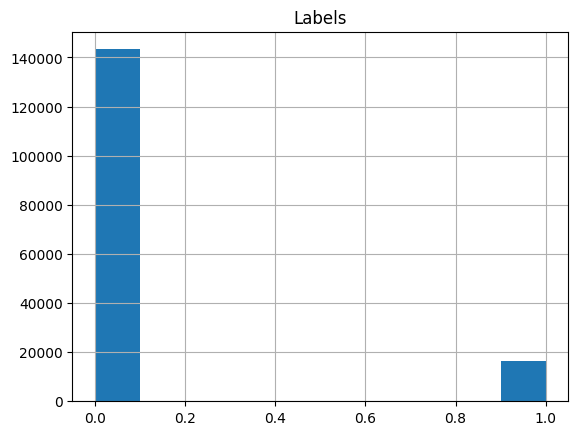

In [7]:
train_data.hist()

In [8]:
train_data['Labels'].value_counts()

Labels
0    143346
1     16225
Name: count, dtype: int64

In [9]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", train_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
train_subset, _ = train_test_split(train_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
train_subset.reset_index(drop=True, inplace=True)
train_under = train_subset
print("After random undersampling", train_under['Labels'].value_counts())

Before random undersampling Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling Labels
0    57280
1     6548
Name: count, dtype: int64


In [10]:
test_data.head()

,Comment,Labels
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [11]:
test_data.shape

(63978, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

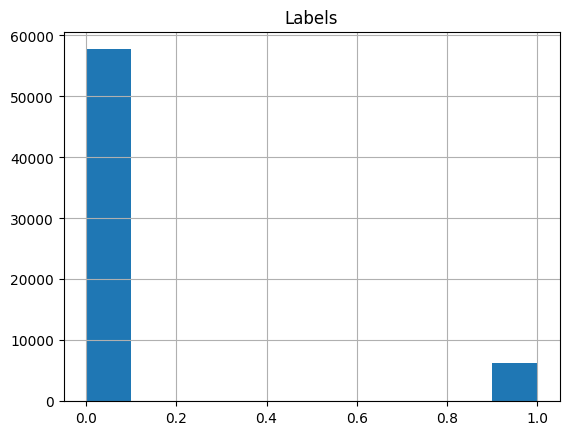

In [12]:
test_data.hist()

In [13]:
test_data['Labels'].value_counts()

Labels
0    57735
1     6243
Name: count, dtype: int64

In [14]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", test_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
test_subset, _ = train_test_split(test_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
test_subset.reset_index(drop=True, inplace=True)
test_under = test_subset
print("After random undersampling", test_under['Labels'].value_counts())

Before random undersampling Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling Labels
0    23130
1     2461
Name: count, dtype: int64


## Create train_texts, train_labels, valid_texts, valid_labels, test_texts, and test_labels

In [15]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(train_under, test_size=0.2, random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [16]:
train_texts = train_data['Comment']
train_texts

0        Christianity is only mentioned three times in ...
1        My Thoughts \n\nYou're a fucking piece of shit...
2        "\nIf you want to customize your userpage, you...
3                          Exactly how are my edits so bad
4        "\n If you'd actually take the time to look ar...
                               ...                        
51057    "\n\nThats not very nice for the people of San...
51058    November 2007 (UTC)\n\nI've been thinking of t...
51059    Track map? \n\nCan a track map be made by jdjo...
51060     "\nOK, but are they ""most"" ? Rajyaमहाराष्ट्र "
51061    William Cooley GA Nomination \n\nHi Horologium...
Name: Comment, Length: 51062, dtype: object

In [17]:
train_labels = train_data['Labels']
train_labels

0        0
1        1
2        0
3        0
4        0
        ..
51057    0
51058    0
51059    0
51060    0
51061    0
Name: Labels, Length: 51062, dtype: int64

In [18]:
valid_texts = val_data['Comment']
valid_texts

0        "\n\nFlyer is right, reliable sources are bein...
1        "\n\n Mistake in Map \n\nHello All,\n\nThe map...
2        "\nHi Rjensen. Thanks for getting back to me. ...
3        I have made no changes to the template, only a...
4        Further update: I've now discovered that the C...
                               ...                        
12761    "\n\nAward ceremony dates\nFound a source for ...
12762    Bio means life or living!! \n\nCell isn't mech...
12763    CJ DUB Continues To Insult Wiki Editors & User...
12764    "\nIf only you had followed your own advice a ...
12765    I think we should see what the RFC determines ...
Name: Comment, Length: 12766, dtype: object

In [19]:
valid_labels = val_data['Labels']
valid_labels

0        0
1        0
2        0
3        0
4        0
        ..
12761    0
12762    0
12763    0
12764    0
12765    0
Name: Labels, Length: 12766, dtype: int64

In [20]:
test_texts = test_under['Comment']
test_texts

0        Clayton High School \n Hello, I recently remov...
1        " \n\n  Please do not vandalize pages, as you ...
2                                  ::Learn to spell, yank.
3        " \n : As a member of the community, I have re...
4        == Eschew Obfuscation == \n\n If you're intere...
                               ...                        
25586    :Are you proposing something here or opining o...
25587    :I don't think there is sufficient reason to e...
25588    " \n\n == The harm of articles == \n\n Accordi...
25589    " \n\n == Local names 2nd time == \n\n  \n\n Y...
25590                fuckin super gay ass bitch headAlamos
Name: Comment, Length: 25591, dtype: object

In [21]:
test_labels = test_under['Labels']
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
25586    0
25587    0
25588    0
25589    0
25590    1
Name: Labels, Length: 25591, dtype: int64

## NLTK & Word2Vec

In [22]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

wvmodel = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [23]:
len(wvmodel)

43981

In [24]:
len(wvmodel['Hi'])

300

In [25]:
EMBEDDING_DIM = len(wvmodel['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(wvmodel) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(wvmodel.index_to_key):
    embedding_vector = wvmodel[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [26]:
embedding_matrix

array([[ 0.0891758 ,  0.121832  , -0.0671959 , ..., -0.0480419 ,
        -0.0277889 ,  0.0872918 ],
       [ 0.0526281 ,  0.013157  , -0.010104  , ...,  0.0209349 ,
        -0.0537912 ,  0.0654217 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 , ..., -0.00832253,
        -0.00398034, -0.0825016 ],
       ...,
       [ 0.0887422 ,  0.0537124 ,  0.0467064 , ..., -0.0794009 ,
         0.0945805 , -0.0361975 ],
       [-0.011512  ,  0.0173624 , -0.0364862 , ..., -0.0425253 ,
         0.0231499 , -0.014217  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [27]:
embedding_matrix.shape

(43982, 300)

In [28]:
embedding_matrix[:5, :2]

array([[ 0.0891758 ,  0.121832  ],
       [ 0.0526281 ,  0.013157  ],
       [ 0.0786419 ,  0.0373911 ],
       [-0.00157585, -0.0564239 ],
       [ 0.0356899 , -0.00367283]])

In [29]:
#@title Data Preparation
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_texts)
valid_tokens = tokenizer.tokenize(valid_texts)
test_tokens = tokenizer.tokenize(test_texts)

In [30]:
train_tokens[0]

<tf.Tensor: shape=(86,), dtype=string, numpy=
array([b'Christianity', b'is', b'only', b'mentioned', b'three', b'times',
       b'in', b'the', b'article', b'so', b'the', b'entire', b'article',
       b"can't", b'have', b'an', b'anti-christian', b'tone.', b'Two',
       b'out', b'of', b'three', b'times,', b'the', b'mention', b'of',
       b'Christianity', b'is', b'in', b'reference', b'to', b'Christians',
       b'and', b'conservatives', b'blaming', b'popular', b'culture',
       b'for', b'the', b'massacre,', b'which', b'actually', b'did',
       b'occur', b'(so', b'it', b'deserves', b'mention).', b'The',
       b'only', b'bias', b'I', b'do', b'notice', b'is', b'the',
       b'mention', b'of', b'using', b'Cassie', b'Bernall', b'to',
       b'boast', b'popularity', b'for', b'their', b'faith', b'despite',
       b'the', b'truth', b'of', b'the', b'matter,', b'but', b'this',
       b'can', b'be', b'easily', b'changed', b'to', b'an', b'NPOV',
       b'without', b'deleting', b'the', b'fact.'], 

In [31]:
valid_tokens[0]

<tf.Tensor: shape=(26,), dtype=string, numpy=
array([b'"', b'Flyer', b'is', b'right,', b'reliable', b'sources', b'are',
       b'being', b'tagged', b'without', b'reason.', b'Your', b'""fact""',
       b'request', b'is', b'above', b'and', b'beyond', b'bordering',
       b'on', b'malicious.', b"You're", b'being', b'completely',
       b'unreasonable.', b'"'], dtype=object)>

In [32]:
test_tokens[0]

<tf.Tensor: shape=(107,), dtype=string, numpy=
array([b'Clayton', b'High', b'School', b'Hello,', b'I', b'recently',
       b'removed', b'edits', b'to', b'Clayton', b'High', b'School',
       b'(Missouri)', b'that', b'were', b'unsourced,', b'and,', b'as',
       b'far', b'as', b'I', b'could', b'tell,', b'not', b'verifiable',
       b'(I', b'did', b'a', b'quick', b'check', b'of', b'Google', b'to',
       b'see', b'who', b'Andreas', b'Thyssen', b'is).', b'I', b'noticed',
       b'that', b'you', b'restored', b'these', b'edits', b'by',
       b'reverting', b'me;', b'if', b'you', b'do', b'have', b'a',
       b'verifiable', b'source', b'to', b'justify', b'the', b'inclusion',
       b'of', b'Thyssen,', b"it's", b'no', b'problem', b'and', b'my',
       b'mistake.', b'However,', b'the', b'description', b'of',
       b'Thyssen', b'seems', b'to', b'violate', b"Wikipedia's", b'Wp:',
       b'NPOV', b'policy', b'in', b'addition', b'to', b'what', b'I',
       b'saw', b'as', b'a', b'verifiability', b'

In [33]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return np.array(texts_vocab_ids)

In [34]:
MAX_SEQUENCE_LENGTH = 100

In [35]:
train_input_ids = docs_to_vocab_ids(train_tokens)
valid_input_ids = docs_to_vocab_ids(valid_tokens)
test_input_ids = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels)
valid_input_labels = np.array(valid_labels)
test_input_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Total examples:  51061
Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Total examples:  12765
Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Total examples:  25590


In [36]:
train_input_ids[:2]

array([[38769, 16908, 25718,  7928, 38823,  5014, 16915, 14193, 14813,
        22793, 14193,  7569, 14813,  1100,  7841, 12291, 43981, 43981,
        30131, 10490, 43981, 38823, 43981, 14193, 40628, 43981, 38769,
        16908, 16915, 16810, 43981, 42587, 43981, 16005, 40903,  4637,
         4476, 11511, 14193, 43981, 32634, 37198, 39090,  3563, 43981,
        16909, 11778, 43981, 15402, 25718, 14863, 12139, 14052, 36750,
        16908, 14193, 40628, 43981,  3969, 43981, 43981, 43981,  8966,
        26351, 11511, 32597,  6275,  7705, 14193, 24191, 43981, 14193,
        43981, 19123, 35029, 25470, 12917, 39945, 41235, 43981, 12291,
        43981,  9370, 43981, 14193, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981],
       [  745, 11933,  5601, 43981, 43981, 38341, 43981, 43981, 22413,
        43981, 43981, 16915, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 4398

In [37]:
valid_input_ids[:2]

array([[43981, 20054, 16908, 43981, 23745, 38221, 42958,  1200, 14551,
         9370, 43981, 23426, 43981,  3378, 16908, 13755, 43981, 37228,
        11886, 20514, 43981,  5601,  1200, 26925, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981],
       [43981, 43981, 16915, 29519,  1980, 43981, 15402, 28242, 25188,
        16915, 35029, 38341,   524, 43981, 33315, 20514, 14193, 17489,
        32623, 14492, 43981, 16971, 16908, 37198, 20514, 1419

In [38]:
test_input_ids[:2]

array([[35168, 43587, 36256, 43981, 12139, 21037, 41785, 43981, 43981,
        35168, 43587, 36256, 43981, 36633, 17433, 43981, 43981, 12292,
        42591, 12292, 12139,  2326, 43981,  3636, 43981, 43981, 39090,
        43981, 41888, 41814, 43981, 43981, 43981, 12737, 10582, 43981,
        43981, 43981, 12139, 16368, 36633, 37008,  6156, 25814, 43981,
        12929, 43981, 43981, 16918, 37008, 14052,  7841, 43981, 43981,
         7398, 43981, 12682, 14193, 25959, 43981, 43981,  7983, 19870,
         2700, 43981, 19334, 43981, 43981, 14193,  8367, 43981, 43981,
        31484, 43981, 30222, 43981, 43981, 43981,  6350, 16915, 16205,
        43981, 31696, 12139, 33954, 12292, 43981, 43981, 43981, 34656,
         9483, 24692, 43981,  7398, 43981, 32907, 14193, 25959, 43981,
        14193],
       [43981, 11199, 14052,  3636, 43981, 43981, 12292, 37008, 39090,
         1331, 35029, 10468, 43981, 17706,  4242,  2776, 43981, 34656,
        37008, 23829, 43981, 14052, 43981, 37008, 43729, 1291

In [39]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

### Classification with various Word2Vec-based Models

In [40]:
training_balance_ratio = sum(train_input_labels)/len(train_input_labels)
print(f'The percentage of positive examples in the training set is: \n{training_balance_ratio}')


The percentage of positive examples in the training set is: 
0.10226783126395363


In [41]:
test_balance_ratio = sum(test_input_labels)/len(test_input_labels)
print(f'The percentage of positive examples in the test set is: \n{test_balance_ratio}')


The percentage of positive examples in the test set is: 
0.09616662107772264


 #### Deep Averaging Network (DAN) - Non-Shuffle

In [42]:
def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=[50, 100],
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.0001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'


  ### YOUR CODE HERE

  dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.

  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings)

  dan_embeddings = dan_embedding_layer(dan_input_layer)
  dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
  last_hidden_output = dan_avg_embeddings

  for i, h_dim in enumerate(hidden_dim):
      last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                  name='dan_hidden_%d' % i)(last_hidden_output)
      last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)

  dan_classification = tf.keras.layers.Dense(1,
                                              activation='sigmoid',
                                              name='dan_classification')(last_hidden_output)
  dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
  dan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                    metrics=['accuracy'])
  ### END YOUR CODE
  return dan_model


In [43]:
### YOUR CODE HERE

dan_model_sorted = create_dan_model()

#use dan_sorted_history = ... below
dan_sorted_history = dan_model_sorted.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=False
                            )

### END YOUR CODE

Epoch 1/10
1596/1596 [==============================] - 11s 4ms/step - loss: 0.3759 - accuracy: 0.9005 - val_loss: 0.7374 - val_accuracy: 0.2605
Epoch 2/10
1596/1596 [==============================] - 7s 5ms/step - loss: 0.2621 - accuracy: 0.9071 - val_loss: 0.9205 - val_accuracy: 0.1039
Epoch 3/10
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2671 - accuracy: 0.8948 - val_loss: 0.8764 - val_accuracy: 0.1066
Epoch 4/10
1596/1596 [==============================] - 8s 5ms/step - loss: 0.2532 - accuracy: 0.9039 - val_loss: 0.9350 - val_accuracy: 0.1115
Epoch 5/10
1596/1596 [==============================] - 7s 4ms/step - loss: 0.2583 - accuracy: 0.8999 - val_loss: 0.8986 - val_accuracy: 0.1443
Epoch 6/10
1596/1596 [==============================] - 8s 5ms/step - loss: 0.2411 - accuracy: 0.9089 - val_loss: 0.9483 - val_accuracy: 0.1571
Epoch 7/10
1596/1596 [==============================] - 7s 4ms/step - loss: 0.2303 - accuracy: 0.9130 - val_loss: 1.0056 - val_accuracy

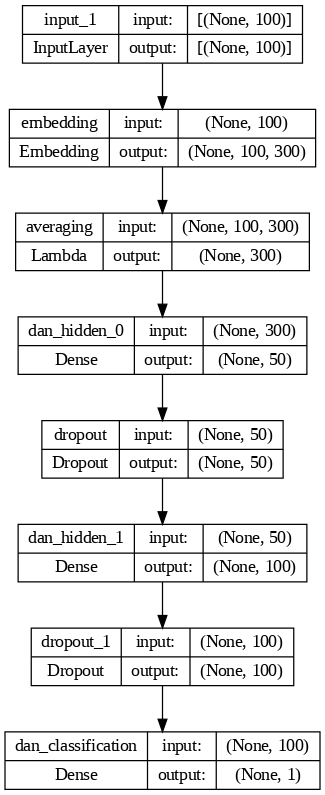

In [44]:
keras.utils.plot_model(dan_model_sorted, show_shapes=True, dpi=90)

In [45]:
dan_model_sorted.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 dan_hidden_0 (Dense)        (None, 50)                15050     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dan_hidden_1 (Dense)        (None, 100)               5100      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0     

800/800 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23     23130
           1       0.11      0.99      0.20      2461

    accuracy                           0.21     25591
   macro avg       0.55      0.56      0.21     25591
weighted avg       0.91      0.21      0.23     25591

ROC AUC Score: 0.6802999160443778


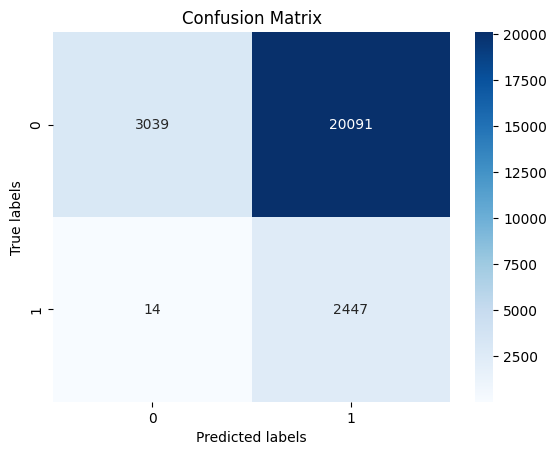

In [46]:
# Make predictions
predictions = dan_model_sorted.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Deep Averaging Network (DAN) - Shuffle

In [47]:
### YOUR CODE HERE

dan_model_shuffled = create_dan_model()

#use dan_shuffled_history = ... below

dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )
### END YOUR CODE

Epoch 1/10
1596/1596 [==============================] - 9s 5ms/step - loss: 0.3582 - accuracy: 0.8977 - val_loss: 0.3068 - val_accuracy: 0.8962
Epoch 2/10
1596/1596 [==============================] - 7s 4ms/step - loss: 0.2925 - accuracy: 0.8984 - val_loss: 0.2851 - val_accuracy: 0.8967
Epoch 3/10
1596/1596 [==============================] - 8s 5ms/step - loss: 0.2746 - accuracy: 0.9003 - val_loss: 0.2720 - val_accuracy: 0.8986
Epoch 4/10
1596/1596 [==============================] - 7s 4ms/step - loss: 0.2616 - accuracy: 0.9034 - val_loss: 0.2610 - val_accuracy: 0.9022
Epoch 5/10
1596/1596 [==============================] - 7s 5ms/step - loss: 0.2510 - accuracy: 0.9067 - val_loss: 0.2511 - val_accuracy: 0.9066
Epoch 6/10
1596/1596 [==============================] - 7s 4ms/step - loss: 0.2413 - accuracy: 0.9100 - val_loss: 0.2441 - val_accuracy: 0.9078
Epoch 7/10
1596/1596 [==============================] - 8s 5ms/step - loss: 0.2341 - accuracy: 0.9128 - val_loss: 0.2372 - val_accuracy:

800/800 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     23130
           1       0.53      0.27      0.36      2461

    accuracy                           0.91     25591
   macro avg       0.73      0.62      0.65     25591
weighted avg       0.89      0.91      0.89     25591

ROC AUC Score: 0.851161561781869


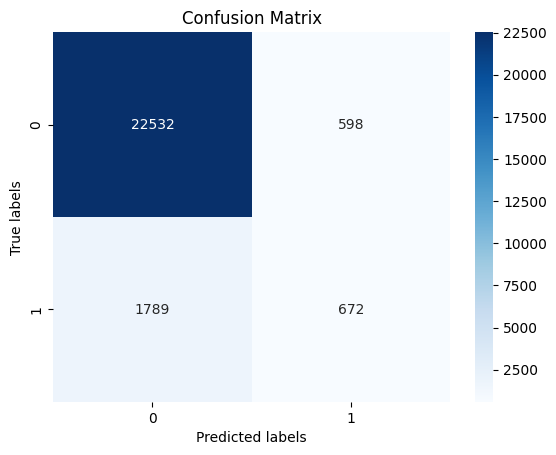

In [48]:
# Make predictions
predictions = dan_model_shuffled.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### DAN MODEL Shuffle vs Non-Shuffle

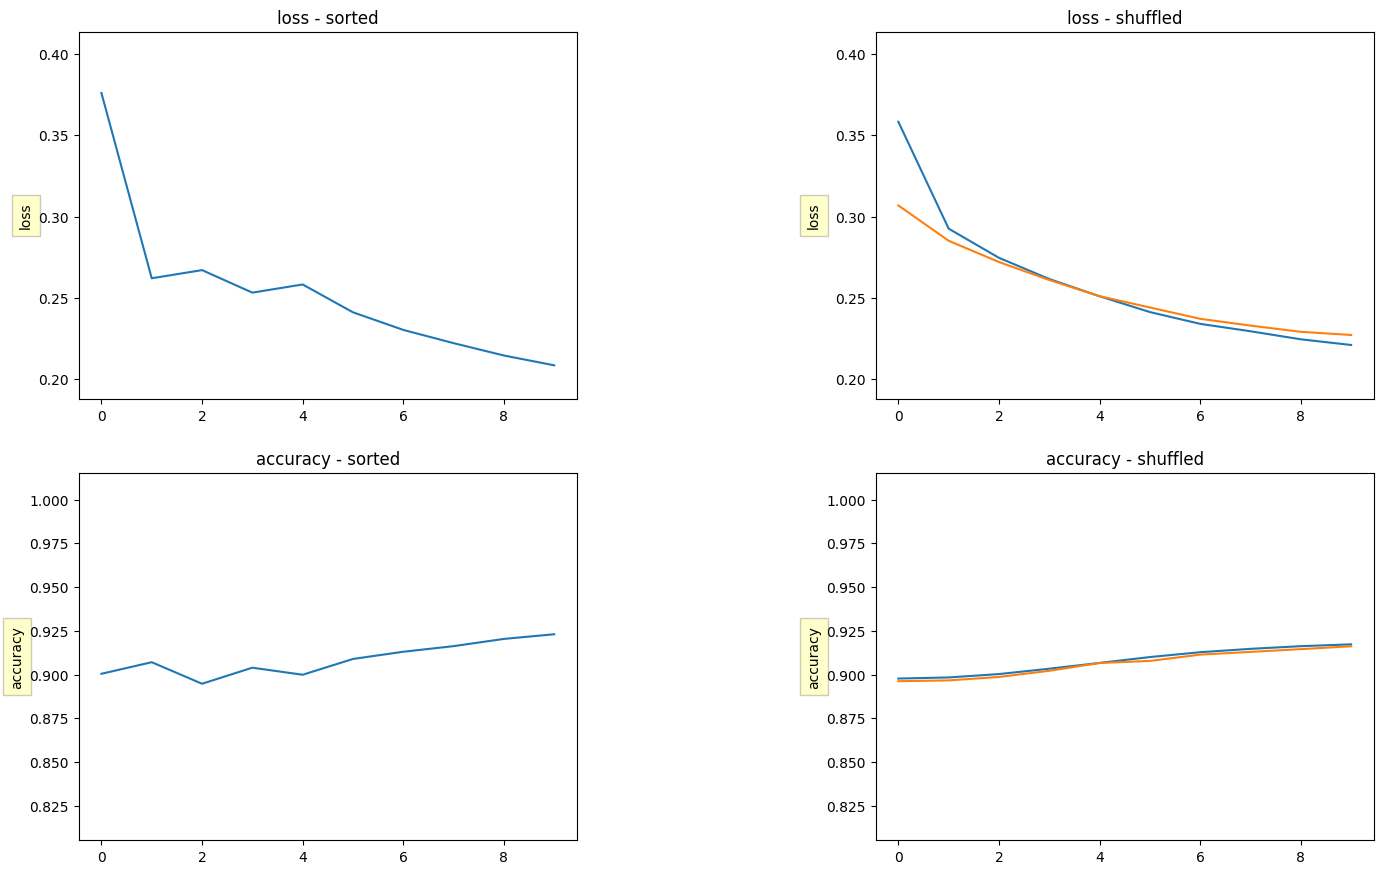

In [49]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_sorted_history,
          dan_shuffled_history,
          model_1_name='sorted',
         model_2_name='shuffled')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

 #### Deep Averaging Network (DAN) - Static

In [50]:
### YOUR CODE HERE

dan_model_static = create_dan_model(retrain_embeddings=False,embedding_initializer='word2vec')

#use dan_static_history = ... below
dan_static_history = dan_model_static.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )

### END YOUR CODE

Epoch 1/10
1596/1596 [==============================] - 8s 4ms/step - loss: 0.3600 - accuracy: 0.8973 - val_loss: 0.3094 - val_accuracy: 0.8962
Epoch 2/10
1596/1596 [==============================] - 7s 5ms/step - loss: 0.2941 - accuracy: 0.8983 - val_loss: 0.2848 - val_accuracy: 0.8969
Epoch 3/10
1596/1596 [==============================] - 7s 4ms/step - loss: 0.2764 - accuracy: 0.9003 - val_loss: 0.2720 - val_accuracy: 0.8985
Epoch 4/10
1596/1596 [==============================] - 8s 5ms/step - loss: 0.2633 - accuracy: 0.9029 - val_loss: 0.2618 - val_accuracy: 0.9026
Epoch 5/10
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2528 - accuracy: 0.9067 - val_loss: 0.2540 - val_accuracy: 0.9049
Epoch 6/10
1596/1596 [==============================] - 7s 5ms/step - loss: 0.2438 - accuracy: 0.9091 - val_loss: 0.2450 - val_accuracy: 0.9077
Epoch 7/10
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2360 - accuracy: 0.9122 - val_loss: 0.2385 - val_accuracy:

800/800 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     23130
           1       0.54      0.24      0.34      2461

    accuracy                           0.91     25591
   macro avg       0.73      0.61      0.64     25591
weighted avg       0.89      0.91      0.89     25591

ROC AUC Score: 0.8497714365722215


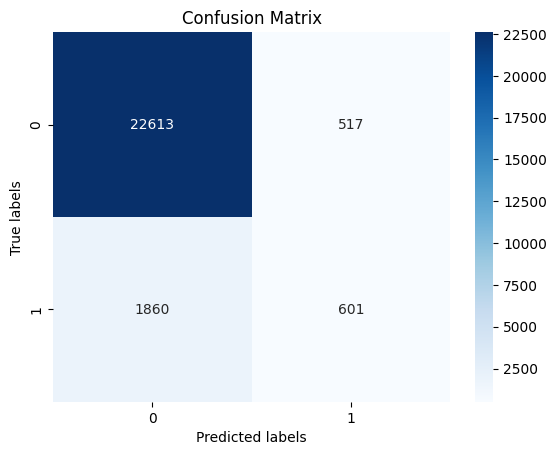

In [51]:
# Make predictions
predictions = dan_model_static.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

 #### Deep Averaging Network (DAN) - retrain_word2vec

In [52]:
### YOUR CODE HERE

dan_model_retrain_word2vec = create_dan_model(retrain_embeddings=True,embedding_initializer='word2vec')

#use dan_static_history = ... below
dan_retrain_word2vec_history = dan_model_retrain_word2vec.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )

### END YOUR CODE

Epoch 1/10
1596/1596 [==============================] - 59s 36ms/step - loss: 0.3421 - accuracy: 0.8971 - val_loss: 0.2959 - val_accuracy: 0.8961
Epoch 2/10
1596/1596 [==============================] - 16s 10ms/step - loss: 0.2650 - accuracy: 0.9025 - val_loss: 0.2487 - val_accuracy: 0.9054
Epoch 3/10
1596/1596 [==============================] - 15s 9ms/step - loss: 0.2186 - accuracy: 0.9180 - val_loss: 0.2252 - val_accuracy: 0.9180
Epoch 4/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1921 - accuracy: 0.9294 - val_loss: 0.2132 - val_accuracy: 0.9223
Epoch 5/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1734 - accuracy: 0.9360 - val_loss: 0.2132 - val_accuracy: 0.9261
Epoch 6/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1596 - accuracy: 0.9416 - val_loss: 0.2139 - val_accuracy: 0.9265
Epoch 7/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1487 - accuracy: 0.9454 - val_loss: 0.2156 - val_

800/800 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     23130
           1       0.53      0.49      0.51      2461

    accuracy                           0.91     25591
   macro avg       0.74      0.72      0.73     25591
weighted avg       0.91      0.91      0.91     25591

ROC AUC Score: 0.8711433687619382


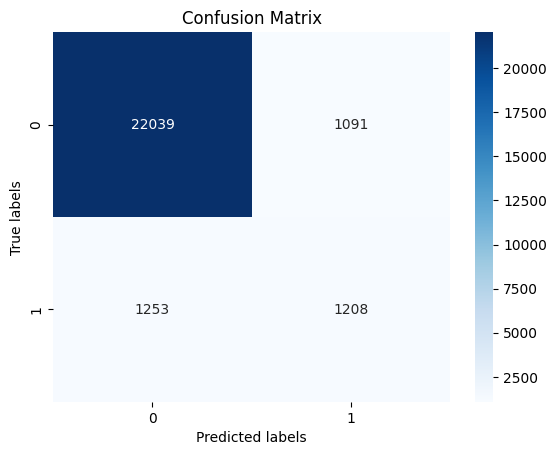

In [53]:
# Make predictions
predictions = dan_model_retrain_word2vec.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

 #### Deep Averaging Network (DAN) - retrain_uniform

In [54]:
### YOUR CODE HERE

dan_model_retrain_uniform = create_dan_model(retrain_embeddings=True,embedding_initializer='uniform')

#use dan_static_history = ... below
dan_retrain_uniform_history = dan_model_retrain_uniform.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )

### END YOUR CODE

Epoch 1/10
1596/1596 [==============================] - 39s 24ms/step - loss: 0.3476 - accuracy: 0.8971 - val_loss: 0.3000 - val_accuracy: 0.8961
Epoch 2/10
1596/1596 [==============================] - 15s 9ms/step - loss: 0.2750 - accuracy: 0.8995 - val_loss: 0.2587 - val_accuracy: 0.9019
Epoch 3/10
1596/1596 [==============================] - 14s 9ms/step - loss: 0.2265 - accuracy: 0.9155 - val_loss: 0.2295 - val_accuracy: 0.9166
Epoch 4/10
1596/1596 [==============================] - 14s 9ms/step - loss: 0.1994 - accuracy: 0.9267 - val_loss: 0.2182 - val_accuracy: 0.9199
Epoch 5/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1804 - accuracy: 0.9346 - val_loss: 0.2167 - val_accuracy: 0.9232
Epoch 6/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1665 - accuracy: 0.9399 - val_loss: 0.2144 - val_accuracy: 0.9268
Epoch 7/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1552 - accuracy: 0.9435 - val_loss: 0.2178 - val_a

800/800 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     23130
           1       0.55      0.45      0.50      2461

    accuracy                           0.91     25591
   macro avg       0.75      0.71      0.72     25591
weighted avg       0.90      0.91      0.91     25591

ROC AUC Score: 0.8713405827844771


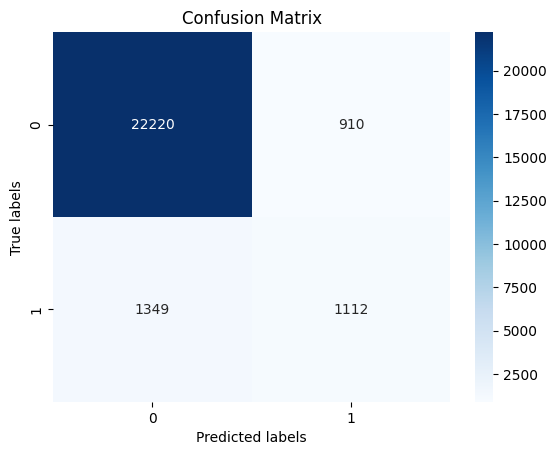

In [55]:
# Make predictions
predictions = dan_model_retrain_uniform.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Weighted Averaging Models (WAN) using Attention

In [56]:
def create_wan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
  """
  Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'

  ### YOUR CODE HERE

  wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')

  # start by creating the wan_embedding_layer. Use the embeddings_initializer. variable defined above.

  wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings)

  # create a learnable query vector for the attention calculation
  wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))

  # wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
  wan_batch_of_ones = tf.repeat(wan_one_vector, repeats=tf.shape(wan_input_layer)[0], axis=0)

  wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])

  wan_query_vector = wan_query_layer(wan_batch_of_ones)

  # define attention layer and reshape
  wan_attention_layer = tf.keras.layers.Attention()


  # Build the model
  wan_embeddings = wan_embedding_layer(wan_input_layer)
  wan_attention_output, wan_attention_weights = wan_attention_layer([wan_query_vector, wan_embeddings], return_attention_scores=True)

  # Reshape the attention output to remove the middle dimension
  wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)


  # Define hidden layers and dropout
  last_hidden_output = wan_attention_output

  for i, h_dim in enumerate([hidden_dim]):
      last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu', name='wan_hidden_%d' % i)(last_hidden_output)
      last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)

  wan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification')(last_hidden_output)

  # # Concatenate query and document encodings to produce a DNN input layer.
  # input_layer = tf.keras.layers.Concatenate()([query_encoding, query_value_attention])



  wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification, wan_attention_weights])
  wan_model.compile(loss=['binary_crossentropy', None],
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                    metrics=['accuracy', None])
  ### END YOUR CODE

  return wan_model


In [57]:
### YOUR CODE HERE

wan_model = create_wan_model()

# use wan_history = ... below

wan_history = wan_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )

### END YOUR CODE

Epoch 1/10
1596/1596 [==============================] - 10s 5ms/step - loss: 0.2576 - classification_loss: 0.2576 - classification_accuracy: 0.9133 - attention_accuracy: 0.0505 - val_loss: 0.2165 - val_classification_loss: 0.2165 - val_classification_accuracy: 0.9234 - val_attention_accuracy: 0.0609
Epoch 2/10
1596/1596 [==============================] - 9s 6ms/step - loss: 0.1994 - classification_loss: 0.1994 - classification_accuracy: 0.9287 - attention_accuracy: 0.0680 - val_loss: 0.2059 - val_classification_loss: 0.2059 - val_classification_accuracy: 0.9268 - val_attention_accuracy: 0.0775
Epoch 3/10
1596/1596 [==============================] - 7s 5ms/step - loss: 0.1903 - classification_loss: 0.1903 - classification_accuracy: 0.9307 - attention_accuracy: 0.0783 - val_loss: 0.2009 - val_classification_loss: 0.2009 - val_classification_accuracy: 0.9296 - val_attention_accuracy: 0.0838
Epoch 4/10
1596/1596 [==============================] - 9s 6ms/step - loss: 0.1849 - classification

In [58]:
wan_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (2,)                         0         ['input_6[0][0]']             
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.getitem (  ()                           0         ['tf.compat.v1.shape[0][0]']  
 SlicingOpLambda)                                                                                 
                                                                                            

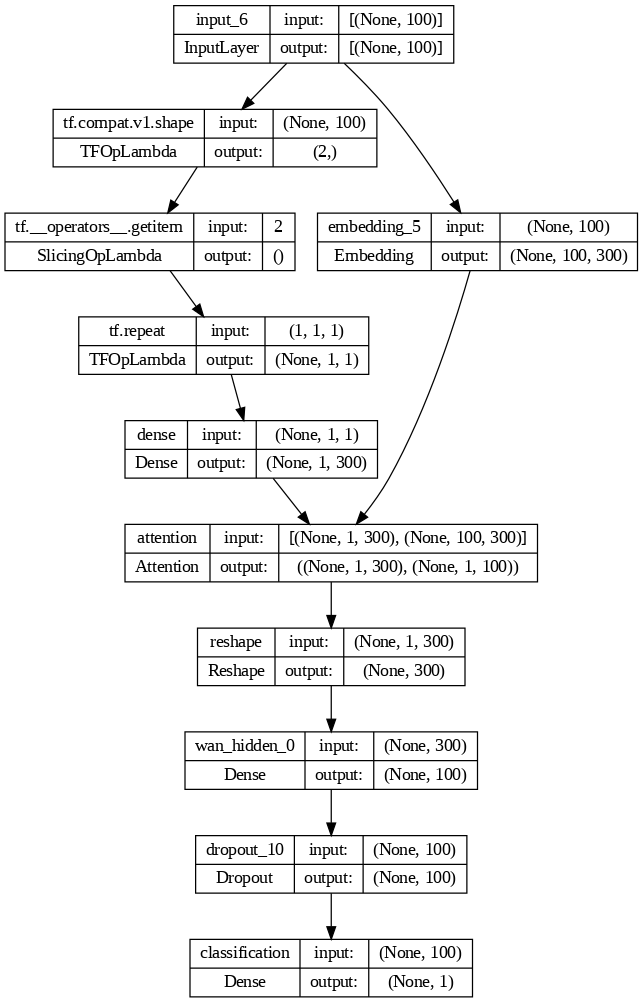

In [59]:
keras.utils.plot_model(wan_model, show_shapes=True, dpi=90)

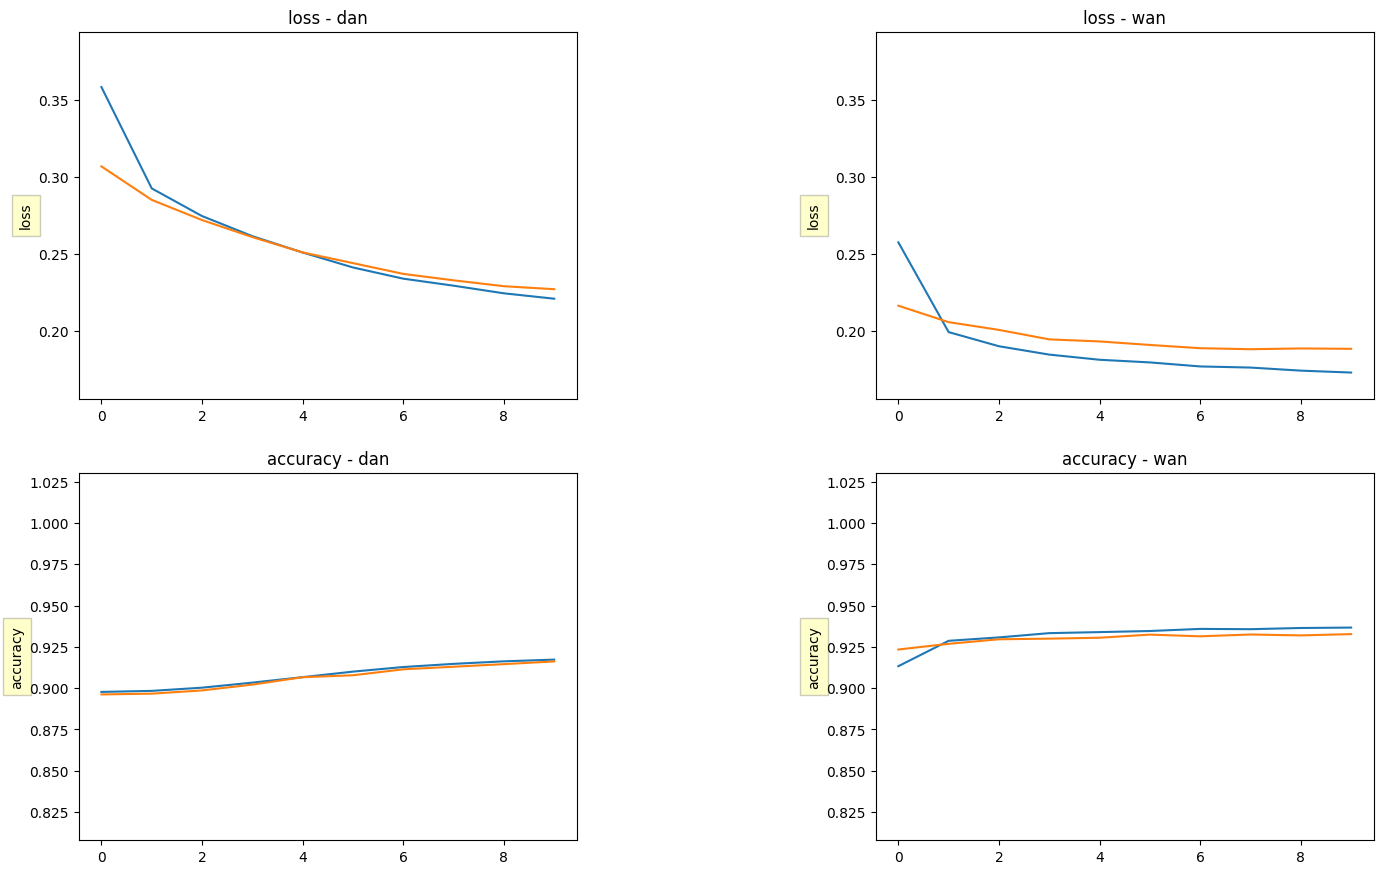

In [60]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_shuffled_history,
          wan_history,
          model_1_name='dan',
         model_2_name='wan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

800/800 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     23130
           1       0.53      0.48      0.50      2461

    accuracy                           0.91     25591
   macro avg       0.74      0.72      0.73     25591
weighted avg       0.91      0.91      0.91     25591

ROC AUC Score: 0.8782204113526834


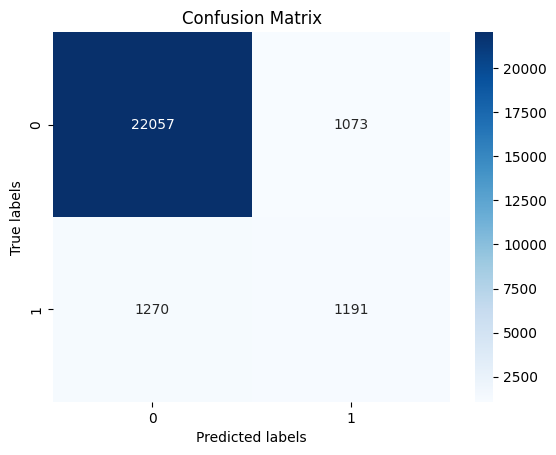

In [61]:
# Make predictions
predictions = wan_model.predict(test_input_ids)[0]
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Convolutional Neural Networks (CNNs) - embedding_trainable==False

In [62]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [63]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model1 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [64]:
cnn_model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 100, 300)             1319460   ['input_7[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 98, 100)              90100     ['embedding_6[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 97, 100)              120100    ['embedding_6[0][0]']   

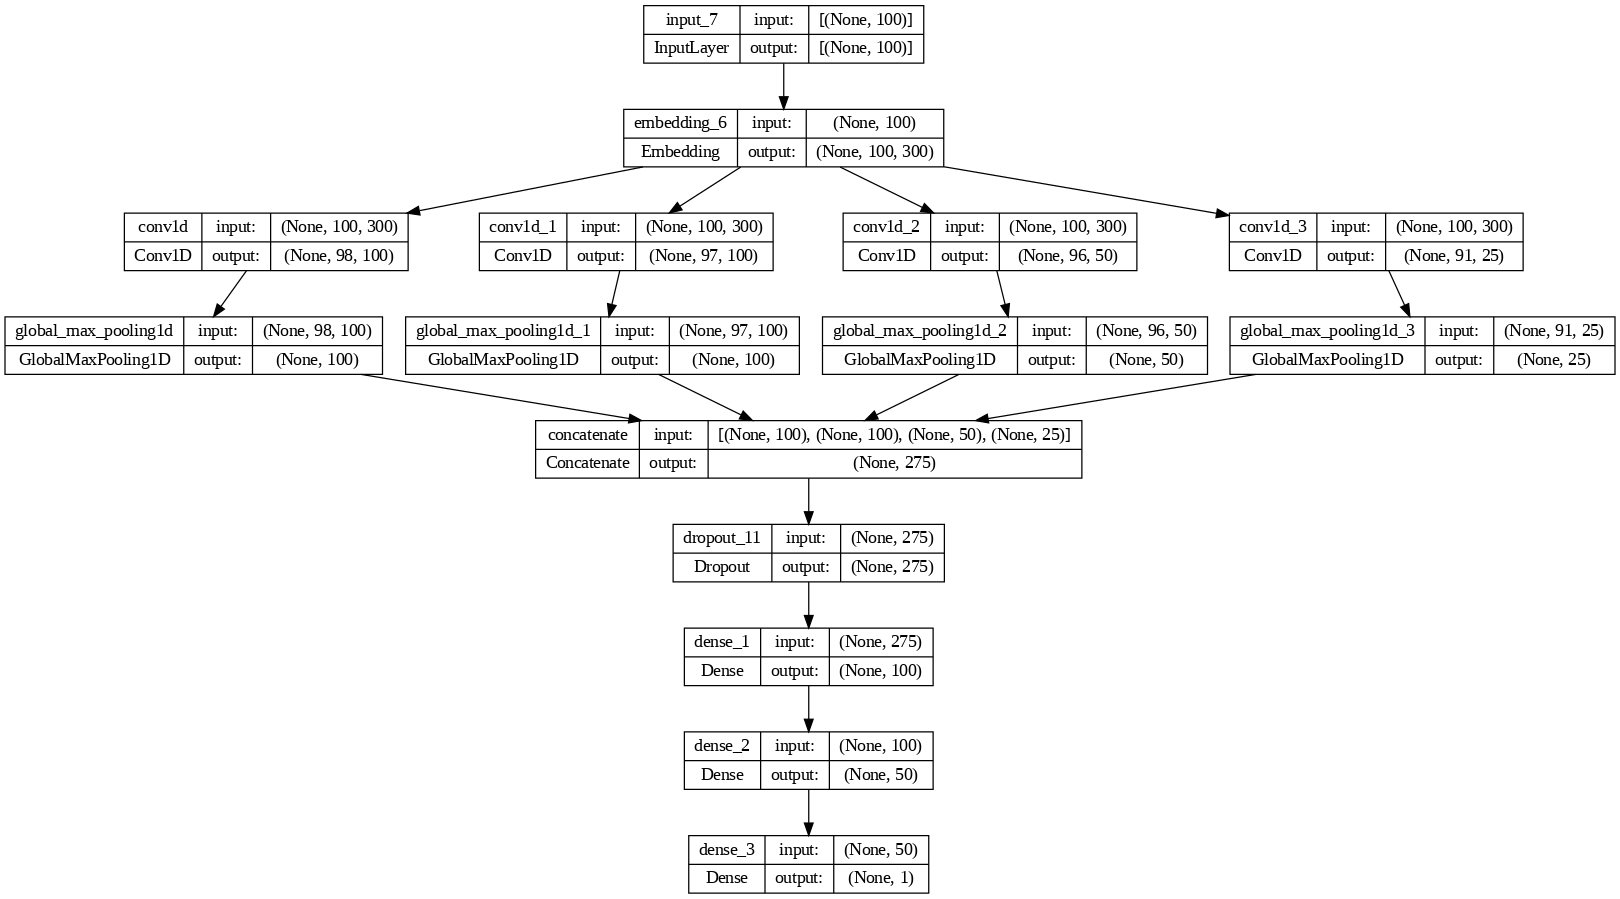

In [65]:
keras.utils.plot_model(cnn_model1, show_shapes=True, dpi=90)

In [66]:
cnn_history1 = cnn_model1.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1596/1596 [==============================] - 18s 8ms/step - loss: 0.2119 - accuracy: 0.9226 - val_loss: 0.1900 - val_accuracy: 0.9346
Epoch 2/10
1596/1596 [==============================] - 12s 8ms/step - loss: 0.1760 - accuracy: 0.9343 - val_loss: 0.1827 - val_accuracy: 0.9341
Epoch 3/10
1596/1596 [==============================] - 12s 8ms/step - loss: 0.1611 - accuracy: 0.9382 - val_loss: 0.1914 - val_accuracy: 0.9341
Epoch 4/10
1596/1596 [==============================] - 11s 7ms/step - loss: 0.1467 - accuracy: 0.9433 - val_loss: 0.1823 - val_accuracy: 0.9350
Epoch 5/10
1596/1596 [==============================] - 12s 7ms/step - loss: 0.1330 - accuracy: 0.9471 - val_loss: 0.1846 - val_accuracy: 0.9366
Epoch 6/10
1596/1596 [==============================] - 12s 8ms/step - loss: 0.1191 - accuracy: 0.9523 - val_loss: 0.1866 - val_accuracy: 0.9330
Epoch 7/10
1596/1596 [==============================] - 12s 7ms/step - loss: 0.1105 - accuracy: 0.9552 - val_loss: 0.2157 - val_ac

800/800 [==============================] - 2s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     23130
           1       0.47      0.57      0.51      2461

    accuracy                           0.90     25591
   macro avg       0.71      0.75      0.73     25591
weighted avg       0.91      0.90      0.90     25591

ROC AUC Score: 0.8820983389294964


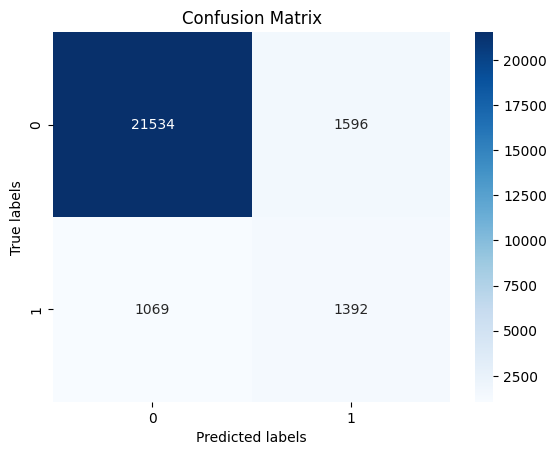

In [67]:
# Make predictions
predictions = cnn_model1.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Convolutional Neural Networks (CNNs) - embedding_trainable==True

In [68]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5
embeddings_trainable = True

cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable)

In [69]:
cnn_history2 = cnn_model2.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1596/1596 [==============================] - 47s 28ms/step - loss: 0.2055 - accuracy: 0.9265 - val_loss: 0.1883 - val_accuracy: 0.9329
Epoch 2/10
1596/1596 [==============================] - 22s 14ms/step - loss: 0.1496 - accuracy: 0.9425 - val_loss: 0.1990 - val_accuracy: 0.9272
Epoch 3/10
1596/1596 [==============================] - 19s 12ms/step - loss: 0.1149 - accuracy: 0.9548 - val_loss: 0.2291 - val_accuracy: 0.9271
Epoch 4/10
1596/1596 [==============================] - 20s 13ms/step - loss: 0.0869 - accuracy: 0.9646 - val_loss: 0.2581 - val_accuracy: 0.9249
Epoch 5/10
1596/1596 [==============================] - 19s 12ms/step - loss: 0.0634 - accuracy: 0.9737 - val_loss: 0.3378 - val_accuracy: 0.9244
Epoch 6/10
1596/1596 [==============================] - 19s 12ms/step - loss: 0.0529 - accuracy: 0.9778 - val_loss: 0.3563 - val_accuracy: 0.9195
Epoch 7/10
1596/1596 [==============================] - 18s 12ms/step - loss: 0.0461 - accuracy: 0.9801 - val_loss: 0.3887 -

800/800 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     23130
           1       0.47      0.51      0.49      2461

    accuracy                           0.90     25591
   macro avg       0.71      0.72      0.72     25591
weighted avg       0.90      0.90      0.90     25591

ROC AUC Score: 0.8514812747692363


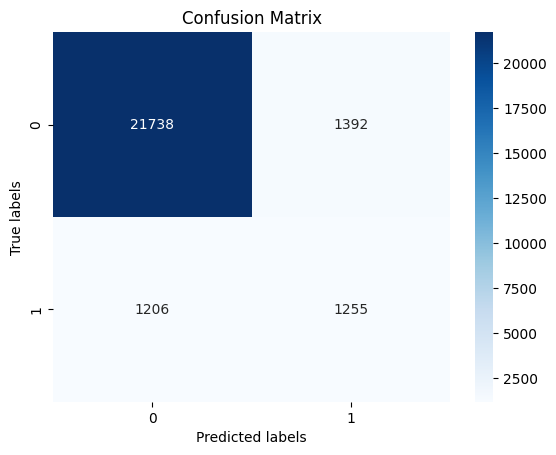

In [70]:
# Make predictions
predictions = cnn_model2.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

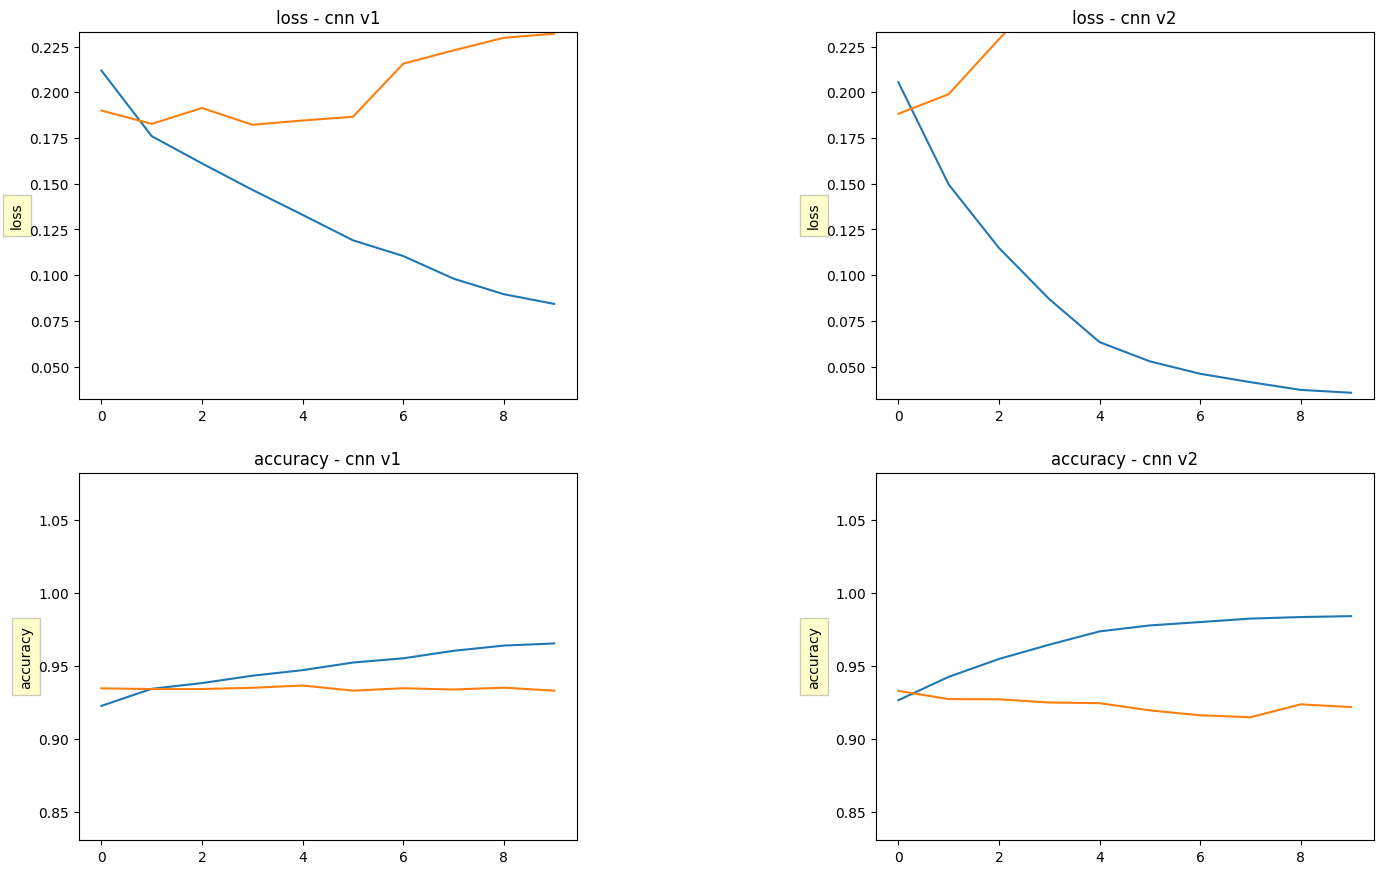

In [71]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history1,
          cnn_history2,
          model_1_name='cnn v1',
          model_2_name='cnn v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

#### Recurrent Neural Network (RNN) - embedding_trainable==False

In [72]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

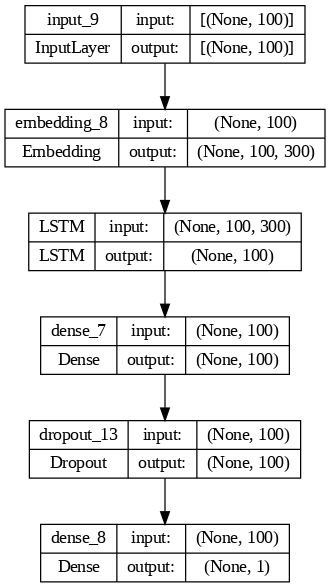

In [73]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model1 = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model1, show_shapes=True, dpi=90)

In [74]:
rnn_history1 = rnn_model1.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1596/1596 [==============================] - 18s 9ms/step - loss: 0.3365 - accuracy: 0.8978 - val_loss: 0.3314 - val_accuracy: 0.8961
Epoch 2/10
1596/1596 [==============================] - 14s 8ms/step - loss: 0.3246 - accuracy: 0.8985 - val_loss: 0.3068 - val_accuracy: 0.8961
Epoch 3/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.3188 - accuracy: 0.8976 - val_loss: 0.3000 - val_accuracy: 0.8961
Epoch 4/10
1596/1596 [==============================] - 14s 9ms/step - loss: 0.2380 - accuracy: 0.9127 - val_loss: 0.2027 - val_accuracy: 0.9228
Epoch 5/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1940 - accuracy: 0.9291 - val_loss: 0.1940 - val_accuracy: 0.9326
Epoch 6/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1828 - accuracy: 0.9338 - val_loss: 0.1957 - val_accuracy: 0.9346
Epoch 7/10
1596/1596 [==============================] - 13s 8ms/step - loss: 0.1771 - accuracy: 0.9349 - val_loss: 0.1816 - val_ac

800/800 [==============================] - 3s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     23130
           1       0.50      0.54      0.52      2461

    accuracy                           0.90     25591
   macro avg       0.73      0.74      0.73     25591
weighted avg       0.91      0.90      0.91     25591

ROC AUC Score: 0.8839116942855892


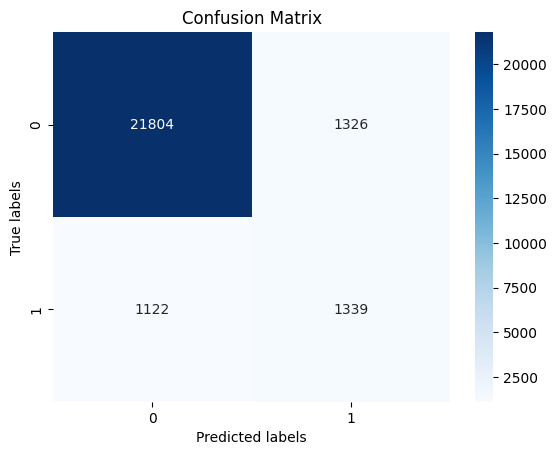

In [75]:
# Make predictions
predictions = rnn_model1.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

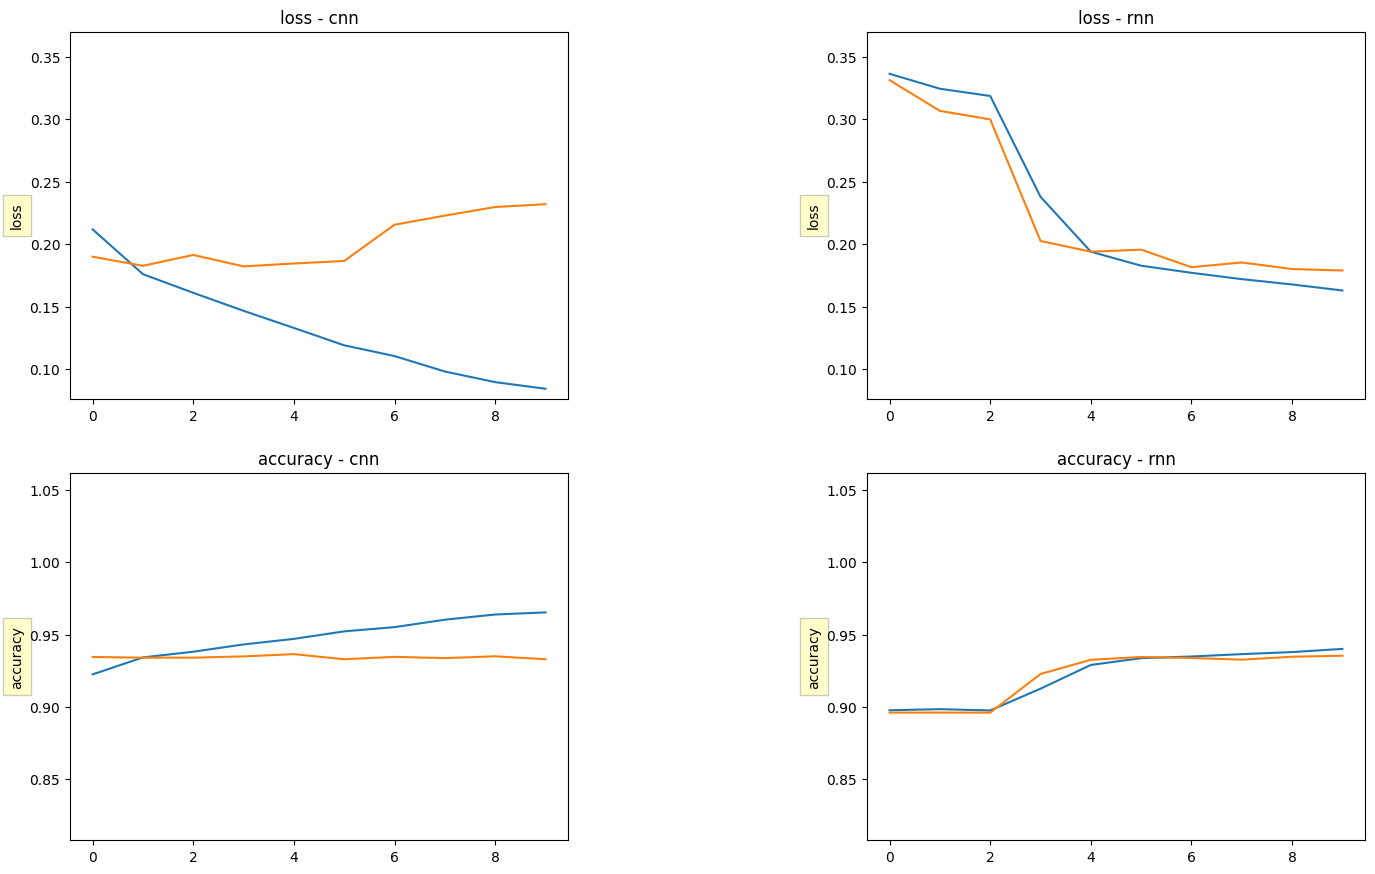

In [76]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history1,
          rnn_history1,
          model_1_name='cnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

#### Recurrent Neural Network (RNN) - embedding_trainable==True

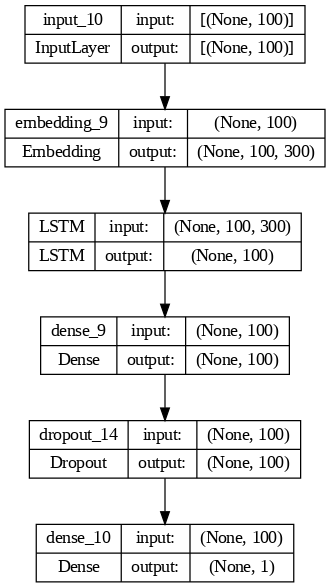

In [77]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model2 = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=True)
keras.utils.plot_model(rnn_model2, show_shapes=True, dpi=90)

In [78]:
rnn_history2 = rnn_model2.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1596/1596 [==============================] - 49s 29ms/step - loss: 0.3284 - accuracy: 0.8974 - val_loss: 0.3307 - val_accuracy: 0.8961
Epoch 2/10
1596/1596 [==============================] - 21s 13ms/step - loss: 0.2349 - accuracy: 0.9180 - val_loss: 0.2066 - val_accuracy: 0.9273
Epoch 3/10
1596/1596 [==============================] - 21s 13ms/step - loss: 0.1641 - accuracy: 0.9414 - val_loss: 0.2047 - val_accuracy: 0.9251
Epoch 4/10
1596/1596 [==============================] - 20s 12ms/step - loss: 0.1293 - accuracy: 0.9523 - val_loss: 0.2251 - val_accuracy: 0.9265
Epoch 5/10
1596/1596 [==============================] - 19s 12ms/step - loss: 0.0993 - accuracy: 0.9622 - val_loss: 0.2461 - val_accuracy: 0.9228
Epoch 6/10
1596/1596 [==============================] - 19s 12ms/step - loss: 0.0766 - accuracy: 0.9708 - val_loss: 0.2828 - val_accuracy: 0.9227
Epoch 7/10
1596/1596 [==============================] - 19s 12ms/step - loss: 0.0598 - accuracy: 0.9768 - val_loss: 0.3234 -

800/800 [==============================] - 3s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     23130
           1       0.45      0.50      0.47      2461

    accuracy                           0.89     25591
   macro avg       0.70      0.72      0.71     25591
weighted avg       0.90      0.89      0.90     25591

ROC AUC Score: 0.8444961898482738


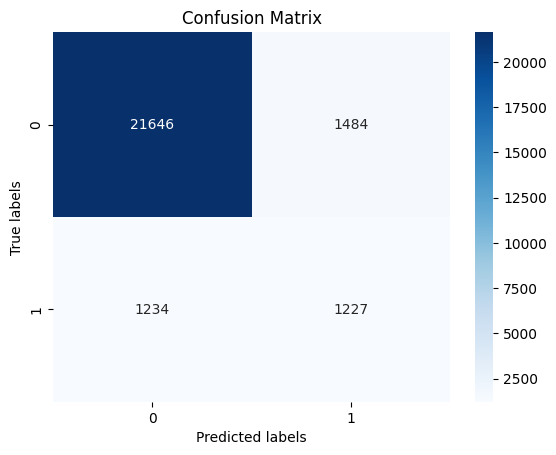

In [79]:
# Make predictions
predictions = rnn_model2.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

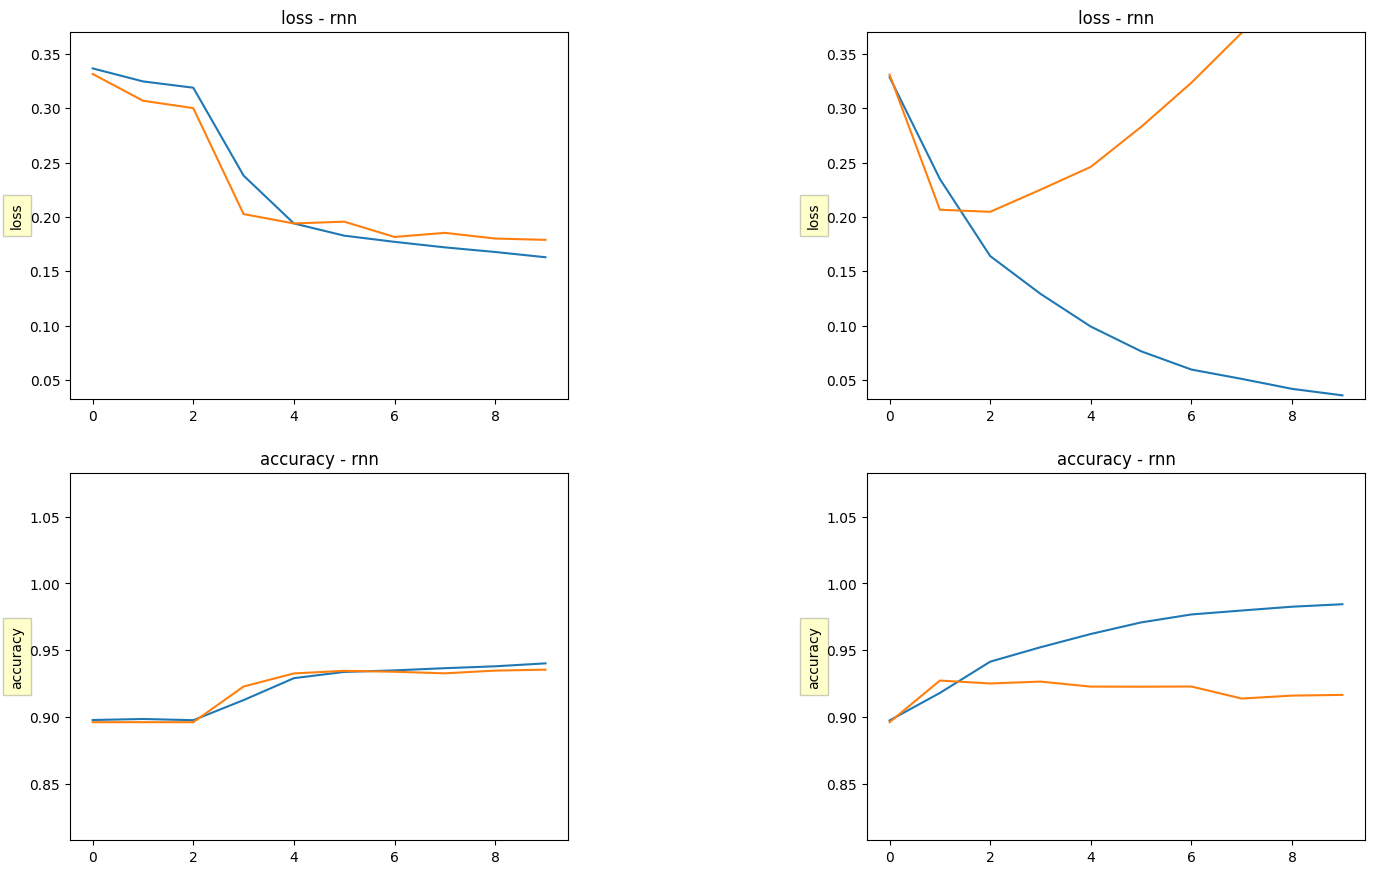

In [80]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          rnn_history1,
          rnn_history2,
          model_1_name='rnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

#### CNN+RNN - embedding_trainable==False

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

def build_cnn_rnn_model(num_filters, kernel_sizes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    # Input and embedding layers
    input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=embeddings_trainable)(input_layer)

    # CNN layers
    conv_layers = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedding_layer)
        pooled = keras.layers.GlobalMaxPooling1D()(conv)
        conv_layers.append(pooled)

    # Concatenate the output of all CNN layers
    cnn_output = keras.layers.concatenate(conv_layers, axis=1)

    # Expand dimensions to feed into LSTM layer
    cnn_output_expanded = tf.expand_dims(cnn_output, axis=1)

    # RNN layer
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, name='LSTM')(cnn_output_expanded)

    # Dense layers
    last_hidden_output = rnn_output
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = Dropout(rate=dropout_rate)(last_hidden_output)

    # Output layer
    prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    # Model
    model = keras.Model(inputs=input_layer, outputs=prediction)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [82]:
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5
rnn_dim = 100

cnn_rnn_model1 = build_cnn_rnn_model(num_filters, kernel_sizes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False)

In [83]:
cnn_rnn_model1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 100, 300)             1319460   ['input_11[0][0]']            
                                                          0                                       
                                                                                                  
 conv1d_8 (Conv1D)           (None, 98, 100)              90100     ['embedding_10[0][0]']        
                                                                                                  
 conv1d_9 (Conv1D)           (None, 97, 100)              120100    ['embedding_10[0][0]'] 

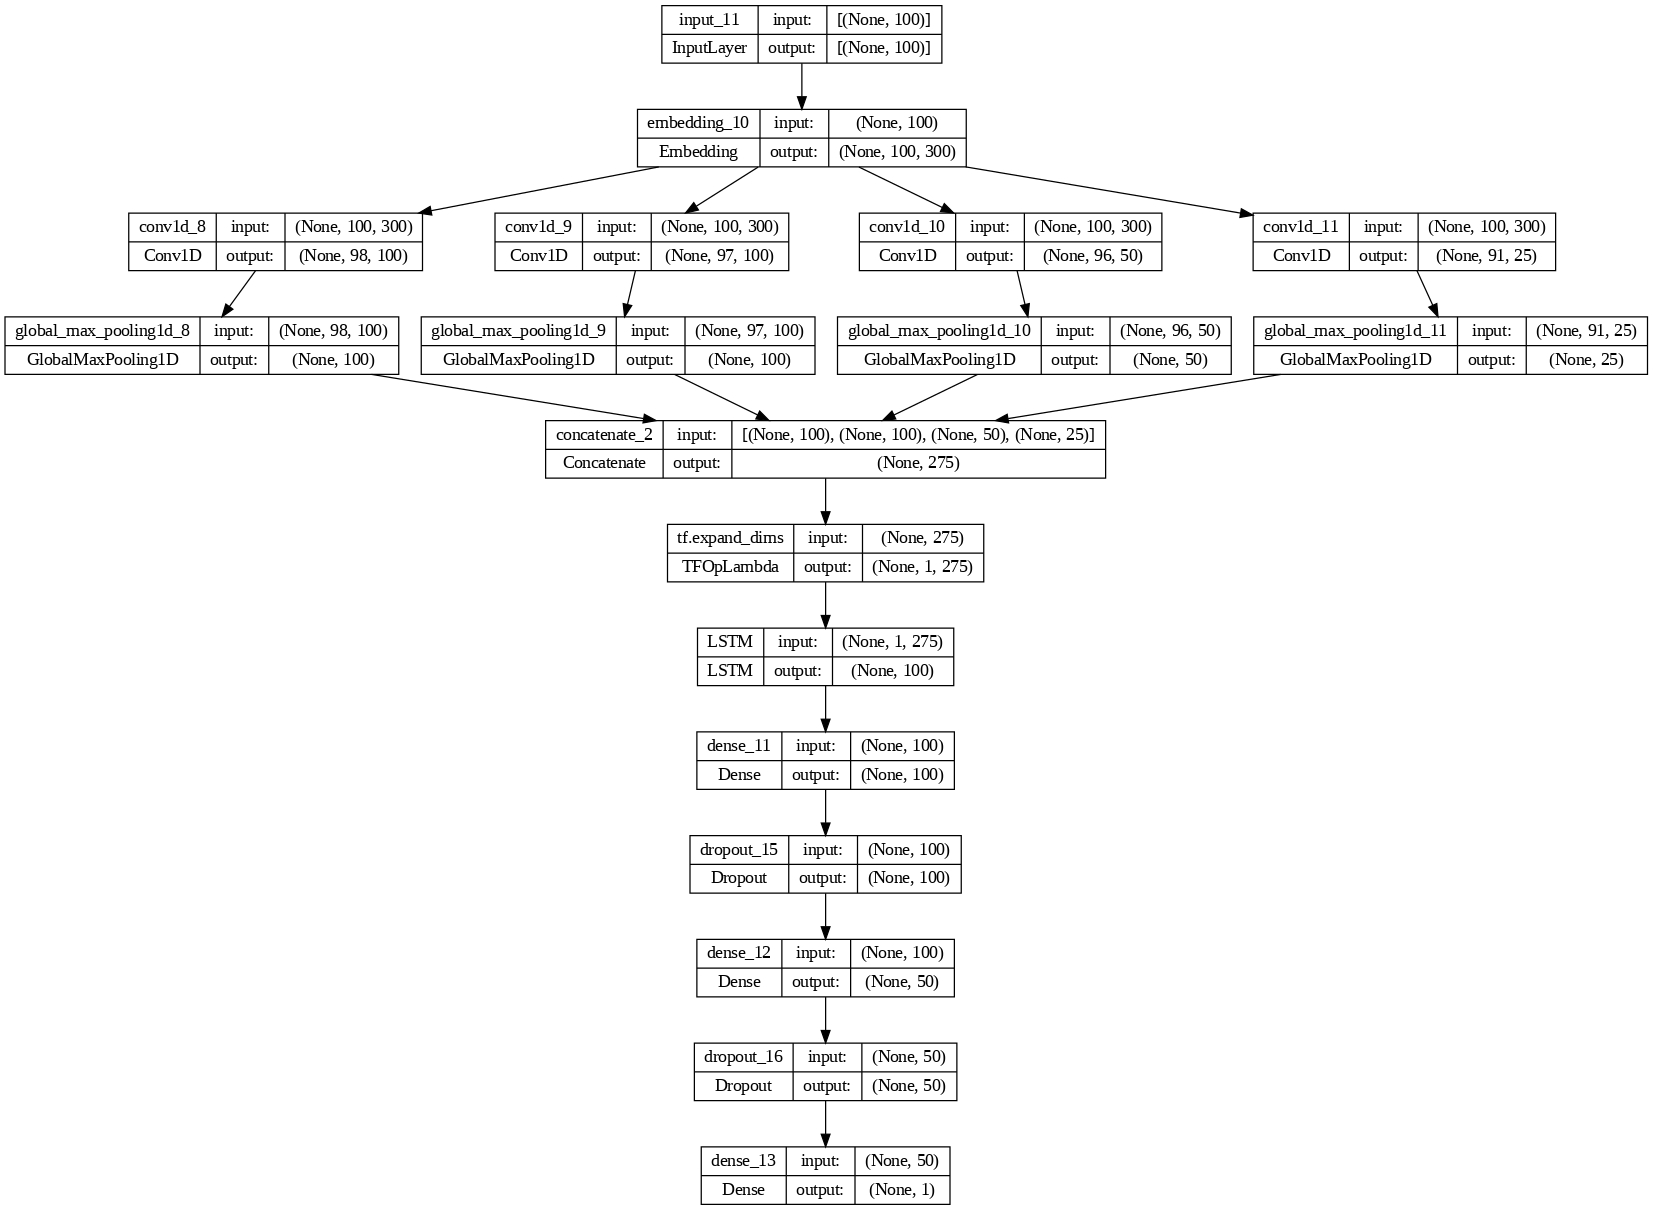

In [84]:
keras.utils.plot_model(cnn_rnn_model1, show_shapes=True, dpi=90)

In [85]:
cnn_rnn_history1 = cnn_rnn_model1.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1596/1596 [==============================] - 19s 10ms/step - loss: 0.2333 - accuracy: 0.9187 - val_loss: 0.2023 - val_accuracy: 0.9254
Epoch 2/10
1596/1596 [==============================] - 14s 9ms/step - loss: 0.1724 - accuracy: 0.9362 - val_loss: 0.1921 - val_accuracy: 0.9300
Epoch 3/10
1596/1596 [==============================] - 15s 9ms/step - loss: 0.1395 - accuracy: 0.9465 - val_loss: 0.2044 - val_accuracy: 0.9276
Epoch 4/10
1596/1596 [==============================] - 14s 9ms/step - loss: 0.1000 - accuracy: 0.9618 - val_loss: 0.2240 - val_accuracy: 0.9282
Epoch 5/10
1596/1596 [==============================] - 14s 9ms/step - loss: 0.0742 - accuracy: 0.9708 - val_loss: 0.3313 - val_accuracy: 0.9259
Epoch 6/10
1596/1596 [==============================] - 15s 9ms/step - loss: 0.0605 - accuracy: 0.9759 - val_loss: 0.3518 - val_accuracy: 0.9192
Epoch 7/10
1596/1596 [==============================] - 16s 10ms/step - loss: 0.0491 - accuracy: 0.9800 - val_loss: 0.4706 - val_

800/800 [==============================] - 4s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     23130
           1       0.43      0.56      0.49      2461

    accuracy                           0.89     25591
   macro avg       0.69      0.74      0.71     25591
weighted avg       0.90      0.89      0.89     25591

ROC AUC Score: 0.8662458344993836


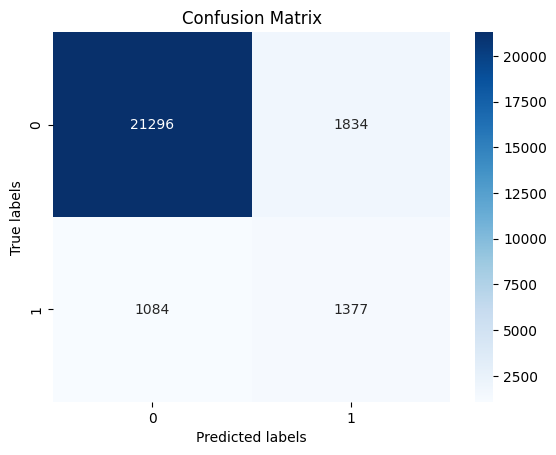

In [86]:
# Make predictions
predictions = cnn_rnn_model1.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### CNN+RNN - embedding_trainable==True

In [87]:
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5
rnn_dim = 100

cnn_rnn_model2 = build_cnn_rnn_model(num_filters, kernel_sizes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=True)

In [88]:
cnn_rnn_history2 = cnn_rnn_model2.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(valid_input_ids, valid_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1596/1596 [==============================] - 52s 30ms/step - loss: 0.2218 - accuracy: 0.9248 - val_loss: 0.1900 - val_accuracy: 0.9322
Epoch 2/10
1596/1596 [==============================] - 24s 15ms/step - loss: 0.1441 - accuracy: 0.9466 - val_loss: 0.2134 - val_accuracy: 0.9300
Epoch 3/10
1596/1596 [==============================] - 22s 14ms/step - loss: 0.0880 - accuracy: 0.9668 - val_loss: 0.2761 - val_accuracy: 0.9246
Epoch 4/10
1596/1596 [==============================] - 22s 14ms/step - loss: 0.0521 - accuracy: 0.9802 - val_loss: 0.3100 - val_accuracy: 0.9181
Epoch 5/10
1596/1596 [==============================] - 21s 13ms/step - loss: 0.0376 - accuracy: 0.9843 - val_loss: 0.4714 - val_accuracy: 0.9264
Epoch 6/10
1596/1596 [==============================] - 21s 13ms/step - loss: 0.0300 - accuracy: 0.9868 - val_loss: 0.5039 - val_accuracy: 0.9173
Epoch 7/10
1596/1596 [==============================] - 21s 13ms/step - loss: 0.0278 - accuracy: 0.9878 - val_loss: 0.5764 -

800/800 [==============================] - 3s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     23130
           1       0.48      0.47      0.48      2461

    accuracy                           0.90     25591
   macro avg       0.71      0.71      0.71     25591
weighted avg       0.90      0.90      0.90     25591

ROC AUC Score: 0.8542722062971811


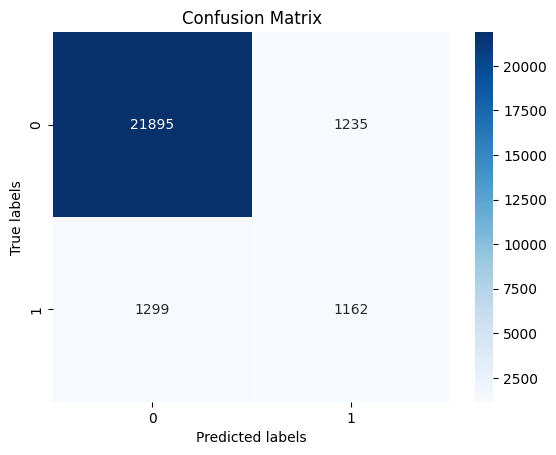

In [89]:
# Make predictions
predictions = cnn_rnn_model2.predict(test_input_ids)
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

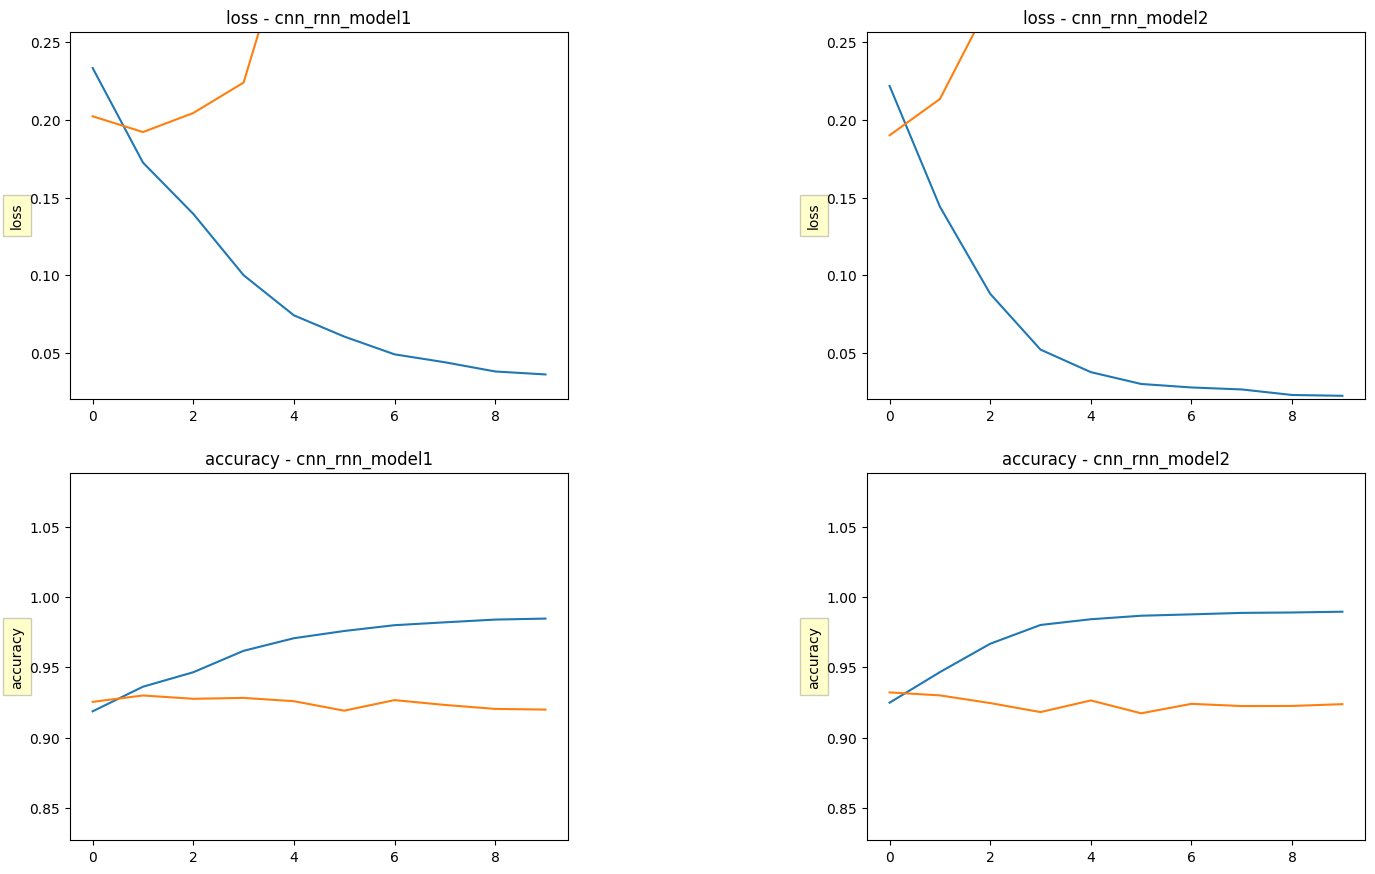

In [90]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_rnn_history1,
          cnn_rnn_history2,
          model_1_name='cnn_rnn_model1',
          model_2_name='cnn_rnn_model2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

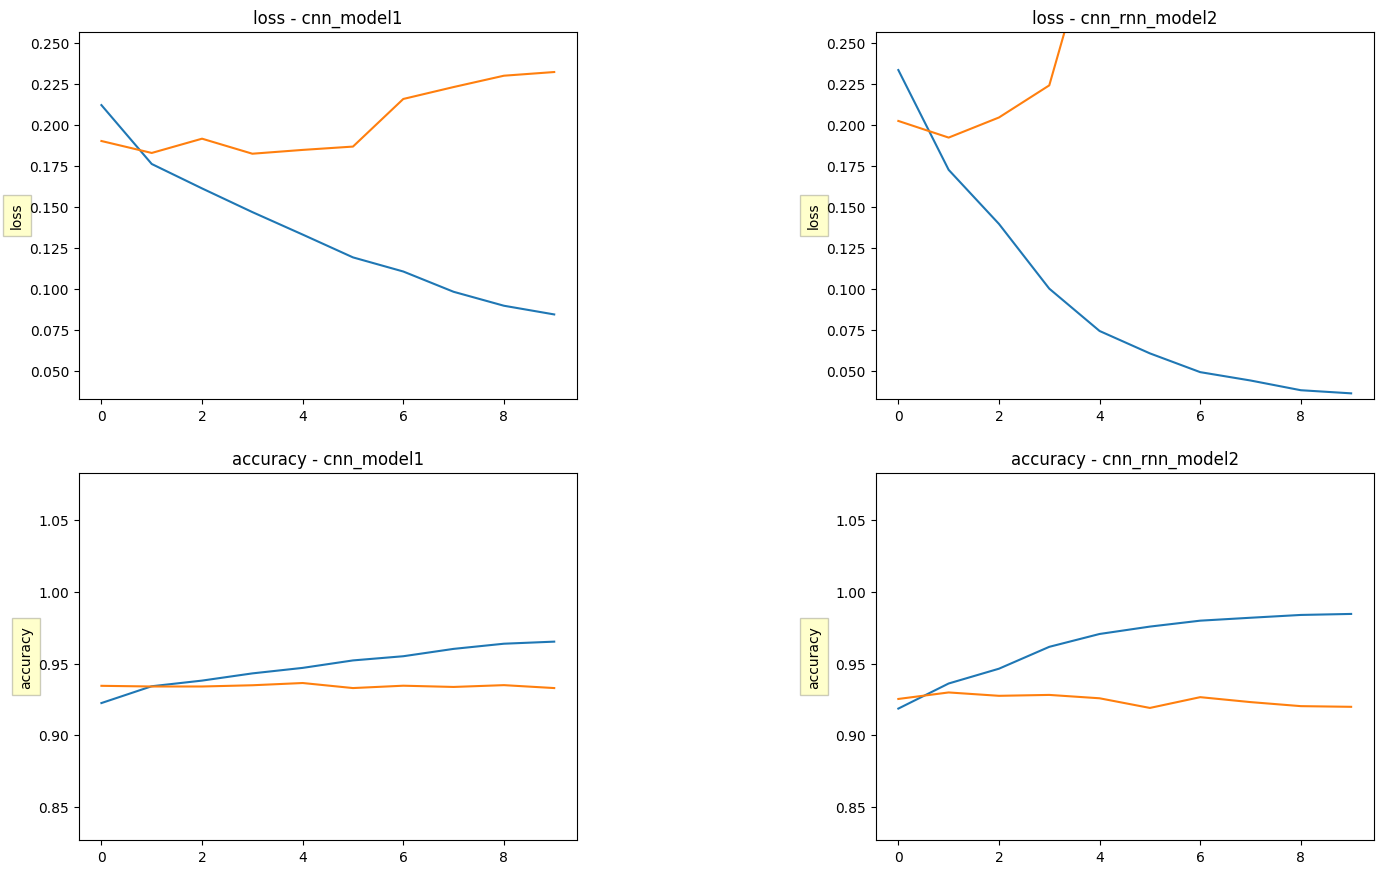

In [91]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history1,
          cnn_rnn_history1,
          model_1_name='cnn_model1',
          model_2_name='cnn_rnn_model2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

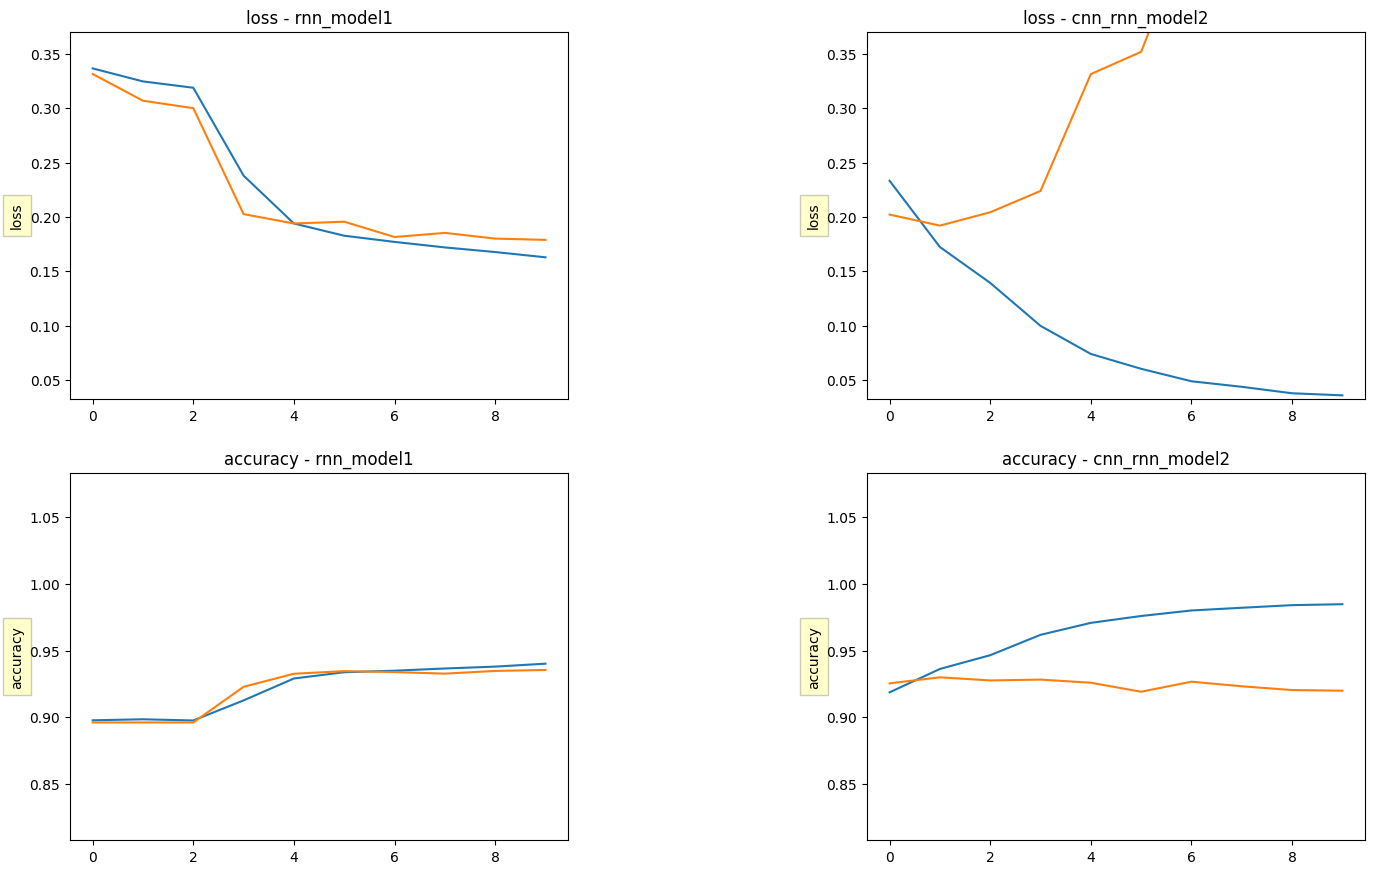

In [93]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          rnn_history1,
          cnn_rnn_history1,
          model_1_name='rnn_model1',
          model_2_name='cnn_rnn_model2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()